In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline

In [252]:
housing_df = pd.read_csv('data/kc_house_data.csv', index_col='id')

# Column Names and Descriptions for King County Data Set
* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors


### First look at the data

What does the data look like in a dataframe and a pairplot?

In [253]:
housing_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


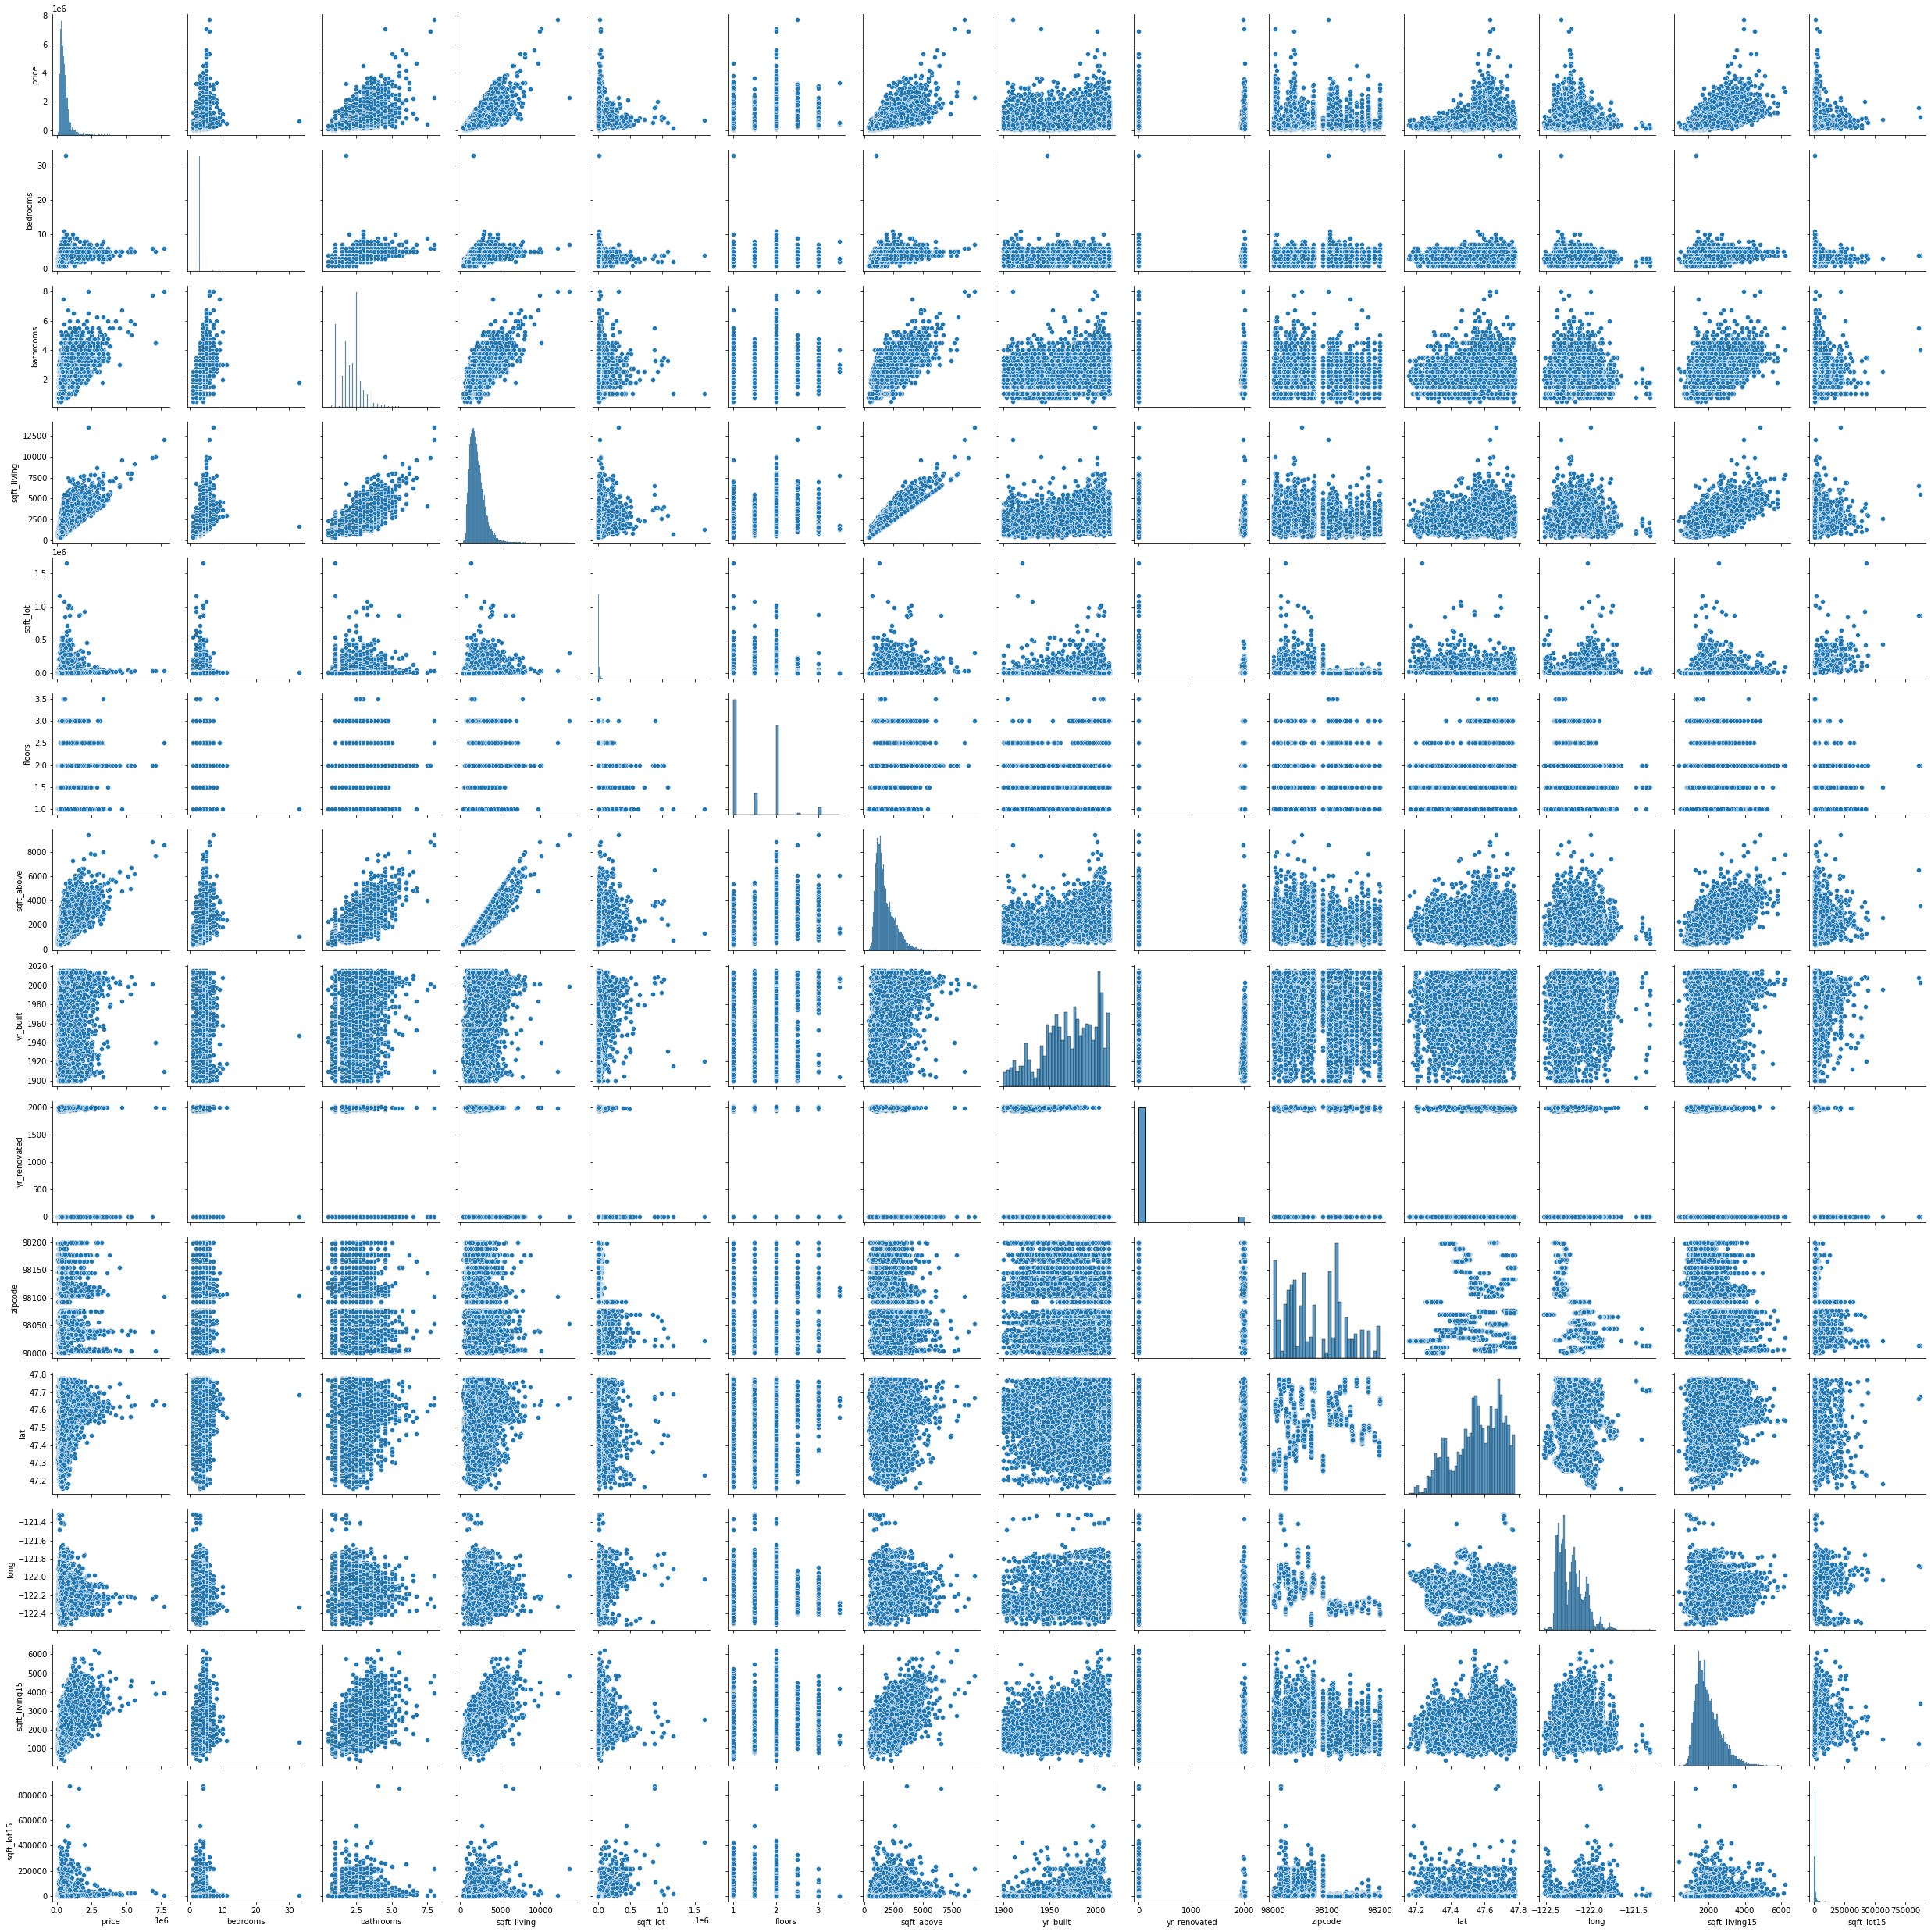

In [171]:
sns.pairplot(housing_df);

### Filling in NaNs

Linear regression models will not run on dataframes which contain NaNs. These need to either be filled in with some sort of value or dropped. After looking at the proportions of missing data and in which columns they occur, we've decided to mostly replace NaNs with the mode of that column.

In [254]:
housing_df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [255]:
column_missing_values_dict = {'waterfront': np.NaN, 'view': np.NaN, 'sqft_basement': '?', 'yr_renovated': np.NaN}

for column_name, missing_value in column_missing_values_dict.items():
    imputer = SimpleImputer(missing_values=missing_value, strategy='most_frequent')
    housing_df[column_name] = imputer.fit_transform(housing_df[column_name].values.reshape(-1,1))[:,0]

In [256]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  object 
 8   view           21597 non-null  object 
 9   condition      21597 non-null  object 
 10  grade          21597 non-null  object 
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float

### Making a Train Test Split

### Fitting a model

Now we'll fit a basic multiple linear regression to the data, dropping any columns that we have yet to convert to numerical data.

In [277]:
X = housing_df.dropna().drop(['price', 'date', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement'], axis=1)
y = housing_df.dropna()['price']

In [283]:
regression = LinearRegression()
regression.fit(X, y)

y_hat = regression.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_hat))
r2 = regression.score(X, y)

print(f'RMSE = {int(round(rmse))} \nR^2 = {round(r2, 3)}')

RMSE = 224074 
R^2 = 0.628


And we'll run a summary in statsmodels just to see some other metrics.

In [279]:
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     2802.
Date:                Tue, 04 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:22:53   Log-Likelihood:            -2.9671e+05
No. Observations:               21597   AIC:                         5.935e+05
Df Residuals:                   21583   BIC:                         5.936e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.208e+07   3.19e+06     -3.783      0.000   -1.83e+07   -5.82e+06
bedrooms      -5.796e+04   2082.563    -27.829      0.000    -6.2e+04   -5.39e+04
bathrooms      5.907e+04   3613.170     16.350      0.000     5.2e+04    6.62e+04
sqft_living     225.2947      4.717     47.761      0.000     216.049     234.541
sqft_lot          0.1973      0.053      3.700      0.000       0.093       0.302
floors         2.429e+04   3984.861      6.095      0.000    1.65e+04    3.21e+04
sqft_above       30.0060      4.733      6.340      0.000      20.729      39.283
yr_built      -2439.4043     73.777    -33.065      0.000   -2584.013   -2294.796
yr_renovated     34.9289      4.366      8.000      0.000      26.371      43.487
zipcode        -573.4821     36.346    -15.778      0.000    -644.723    -502.241
lat            6.274e+05   1.17e+04     53.479      0.000    6.04e+05     6.5e+05
long          -3.533e+05   1.44e+04    -24.472      0.000   -3.82e+05   -3.25e+05
sqft_living15    87.5834      3.610     24.262      0.000      80.508      94.659
sqft_lot15       -0.4017      0.082     -4.920      0.000      -0.562      -0.242
==============================================================================
Omnibus:                    17424.431   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1142735.654
Skew:                           3.415   Prob(JB):                         0.00
Kurtosis:                      37.975   Cond. No.                     2.11e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Cleaning up important columns

The waterfront, view, condition, and grade columns should all be numeric. We'll clean those up with a few assorted in-place adjustments.

In [259]:
housing_df['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [260]:
housing_df.loc[:,'grade'] = housing_df.copy().loc[:,'grade'].apply(lambda x: int(x[0]))
housing_df['grade'].value_counts()

7    8974
8    6065
9    2615
6    2038
1    1635
5     242
4      27
3       1
Name: grade, dtype: int64

In [261]:
print(housing_df['view'].value_counts())
print(housing_df['condition'].value_counts())
print(housing_df['waterfront'].value_counts())

NONE         19485
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64
Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64
NO     21451
YES      146
Name: waterfront, dtype: int64


In [262]:
view_values = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
condition_values = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
waterfront_values = ['NO', 'YES']

values_dict = {'view': view_values, 'condition': condition_values, 'waterfront': waterfront_values}

for column_name, values_list in values_dict.items():    
    for num, value in enumerate(values_list):
        housing_df.loc[housing_df[column_name] == value, column_name] = int(num)
    housing_df[column_name] = housing_df[column_name].astype(int)

housing_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,2,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,2,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,2,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,4,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,2,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


We'll also convert the date column to pandas datetime values and the sqft_basement and grade columns into numeric columns.

In [263]:
housing_df.loc[:, 'date'] = pd.to_datetime(housing_df.loc[:, 'date'])
housing_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,2,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,2,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,2,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,4,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,2,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [264]:
housing_df['sqft_basement'] = housing_df['sqft_basement'].astype(float)
housing_df['grade'] = housing_df['grade'].astype(int)

In [265]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  float64       
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   view           21597 non-null  int64         
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  float64       
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  float64       
 15  zipco

### Now we'll train a model using all the columns, except for date.

But first we'll make a train-test split.

In [287]:
X = housing_df.drop(['price', 'date'], axis=1)
y = housing_df['price']

In [289]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    random_state=1)

regression = LinearRegression()
regression.fit(X_train, y_train)

y_hat = regression.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_hat))
r2 = regression.score(X_train, y_train)

print(f'RMSE = {round(rmse, 3)}. \nR^2 = {round(r2, 3)}')

RMSE = 208219.567. 
R^2 = 0.682


In [290]:
sm.OLS(y_train, sm.add_constant(X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     2060.
Date:                Tue, 04 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:50:09   Log-Likelihood:            -2.3610e+05
No. Observations:               17277   AIC:                         4.722e+05
Df Residuals:                   17258   BIC:                         4.724e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -1.91e+06   3.37e+06     -0.567      0.571   -8.51e+06     4.7e+06
bedrooms       -3.97e+04   2186.632    -18.156      0.000    -4.4e+04   -3.54e+04
bathrooms      5.139e+04   3748.102     13.711      0.000     4.4e+04    5.87e+04
sqft_living     142.1978     22.535      6.310      0.000      98.026     186.369
sqft_lot          0.1294      0.054      2.377      0.017       0.023       0.236
floors         3.275e+04   4175.537      7.843      0.000    2.46e+04    4.09e+04
waterfront     6.041e+05   2.09e+04     28.858      0.000    5.63e+05    6.45e+05
view           5.978e+04   2432.668     24.572      0.000     5.5e+04    6.45e+04
condition      3.175e+04   2714.336     11.696      0.000    2.64e+04    3.71e+04
grade         -2.257e+04    893.382    -25.259      0.000   -2.43e+04   -2.08e+04
sqft_above       86.1108     22.477      3.831      0.000      42.054     130.167
sqft_basement    42.9896     22.320      1.926      0.054      -0.760      86.739
yr_built      -1732.6149     81.510    -21.257      0.000   -1892.382   -1572.848
yr_renovated     37.2101      4.617      8.060      0.000      28.161      46.259
zipcode        -657.3371     37.995    -17.300      0.000    -731.812    -582.863
lat            6.795e+05   1.22e+04     55.689      0.000    6.56e+05    7.03e+05
long          -3.066e+05   1.51e+04    -20.300      0.000   -3.36e+05   -2.77e+05
sqft_living15    58.9834      3.832     15.393      0.000      51.473      66.494
sqft_lot15       -0.4744      0.082     -5.791      0.000      -0.635      -0.314
==============================================================================
Omnibus:                    13516.931   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1095124.280
Skew:                           3.170   Prob(JB):                         0.00
Kurtosis:                      41.485   Cond. No.                     2.14e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Train-test split at beginning

Get all columns (including feature engineering (maybe) and dummies).

run model (cross validate)
run model (cross validate)
etc.


In [296]:
housing_df[housing_df['bedrooms'] > 8]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
1997200215,2014-05-07,599999.0,9,4.50,3830,6988,2.5,0,0,2,7,2450,1380.0,1938,0.0,98103,47.6927,-122.338,1460,6291
2902200015,2015-01-06,700000.0,9,3.00,3680,4400,2.0,0,0,2,7,2830,850.0,1908,0.0,98102,47.6374,-122.324,1960,2450
9822700190,2014-08-08,1280000.0,9,4.50,3650,5000,2.0,0,0,2,8,2530,1120.0,1915,2010.0,98105,47.6604,-122.289,2510,5000
424049043,2014-08-11,450000.0,9,7.50,4050,6504,2.0,0,0,2,7,4050,0.0,1996,0.0,98144,47.5923,-122.301,1448,3866
1773100755,2014-08-21,520000.0,11,3.00,3000,4960,2.0,0,0,2,7,2400,600.0,1918,1999.0,98106,47.5560,-122.363,1420,4960
627300145,2014-08-14,1150000.0,10,5.25,4590,10920,1.0,0,2,2,9,2500,2090.0,2008,0.0,98004,47.5861,-122.113,2730,10400
5566100170,2014-10-29,650000.0,10,2.00,3610,11914,2.0,0,0,3,7,3010,600.0,1958,0.0,98006,47.5705,-122.175,2040,11914
2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,4,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700
8823900290,2015-03-17,1400000.0,9,4.00,4620,5508,2.5,0,0,2,1,3870,750.0,1915,0.0,98105,47.6684,-122.309,2710,4320
